# Dissipation and Dispersion Analysis
## Wave Equation — Theta Method & Newmark Method

We analyse the **dissipation** (amplitude error / energy loss) and **dispersion**
(phase-velocity error) introduced by five fully-discrete schemes for the wave
equation on $\Omega = [0,1]^2$ with homogeneous Dirichlet BCs:

| Scheme | Parameters |
|--------|------------|
| Theta FE (Forward Euler) | $\theta = 0$ |
| Theta CN (Crank–Nicolson) | $\theta = 0.5$ |
| Theta BE (Backward Euler) | $\theta = 1$ |
| Newmark (Central Difference) | $\beta = 0,\; \gamma = 0.5$ |
| Newmark (Average Acceleration) | $\beta = 0.25,\; \gamma = 0.5$ |

**Test case** — standing mode with known exact solution:
$$u(x,y,t) = \cos\!\bigl(\sqrt{2}\,\pi\,t\bigr)\,\sin(\pi x)\,\sin(\pi y), \qquad \omega_{\mathrm{exact}} = \sqrt{2}\,\pi$$

The spatial mesh is fixed (fine enough to isolate temporal errors), and $\Delta t$
is varied.

### Approach
1. **Dissipation** is measured via the discrete energy $E^n = \tfrac12(\mathbf{v}^T M \mathbf{v} + \mathbf{u}^T K \mathbf{u})$. The exact solution conserves energy, so $E(T)/E(0) < 1$ reveals numerical dissipation.
2. **Dispersion** is measured via the relative $L^2$ error growth over time — phase errors cause the numerical and exact solutions to drift apart periodically.
3. **Theoretical amplification factors** for each scheme are computed analytically and compared to the measured values.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import os, warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
plt.rcParams.update({
    "figure.figsize": (12, 5),
    "font.size": 12,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# Exact solution parameters
OMEGA_EXACT = np.sqrt(2) * np.pi   # rad/s
ALPHA_EXACT = 0.0                   # no damping

# Consistent colour scheme for all plots
SCHEME_COLORS = {
    "theta-0.0":    "#1f77b4",  # blue   — Forward Euler
    "theta-0.5":    "#2ca02c",  # green  — Crank-Nicolson
    "theta-1.0":    "#d62728",  # red    — Backward Euler
    "newmark-0.00": "#17becf",  # cyan   — Central Difference
    "newmark-0.25": "#ff7f0e",  # orange — Average Acceleration
}
SCHEME_LABELS = {
    "theta-0.0":    r"$\theta$-FE ($\theta=0$)",
    "theta-0.5":    r"$\theta$-CN ($\theta=0.5$)",
    "theta-1.0":    r"$\theta$-BE ($\theta=1$)",
    "newmark-0.00": r"Newmark CD ($\beta=0$)",
    "newmark-0.25": r"Newmark AA ($\beta=0.25$)",
}
SCHEME_MARKERS = {
    "theta-0.0": "o", "theta-0.5": "s", "theta-1.0": "^",
    "newmark-0.00": "D", "newmark-0.25": "P",
}

# Directories — adjust if needed
SCRIPT_DIR = Path("../scripts").resolve()
DATA_DIR   = Path("data").resolve()
FIG_DIR    = Path("figures/dissipation-dispersion").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"Script dir:  {SCRIPT_DIR}")
print(f"Data dir:    {DATA_DIR}")
print(f"Figures dir: {FIG_DIR}")
print("Setup OK.")

Script dir:  /home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/scripts
Data dir:    /home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/analysis/data
Figures dir: /home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/analysis/figures/dissipation-dispersion
Setup OK.


## 1. Theoretical Amplification Factors

Before looking at simulation data, we derive the **exact amplification factor** $g(\omega \Delta t)$
for each scheme applied to the scalar ODE $\ddot u + \omega^2 u = 0$
(the modal equation after spatial discretisation).

### Theta method
The $\theta$-method applied to the first-order system $\dot{\mathbf{y}} = A\mathbf{y}$ yields:
$$g(\Omega) = \frac{1 - (1-\theta)^2 \Omega^2}{1 + \theta^2 \Omega^2}, \qquad \Omega = \omega\,\Delta t$$

- $\theta=0$ (FE): $|g| = |1 - \Omega^2|$, conditionally stable for $\Omega < 1$
- $\theta=0.5$ (CN): $|g| = 1$ always → **no dissipation**
- $\theta=1$ (BE): $|g| = 1/(1+\Omega^2) < 1$ → **maximum dissipation**

### Newmark method
$$g(\Omega) = \frac{1 - (1/2-\beta)\Omega^2}{1 + \beta\,\Omega^2}$$

- $\beta=0$ (CD): $|g| = |1 - \Omega^2/2|$, conditionally stable for $\Omega < 2$
- $\beta=0.25$ (AA): $|g| = 1$ always → **no dissipation**

### Numerical dispersion
The numerical frequency $\tilde\omega$ is obtained from $g = e^{-i\tilde\omega\Delta t}$:
$$\frac{\tilde\omega}{\omega} = \frac{\arctan\!\bigl(\mathrm{Im}(g)/\mathrm{Re}(g)\bigr)}{\omega\,\Delta t}$$

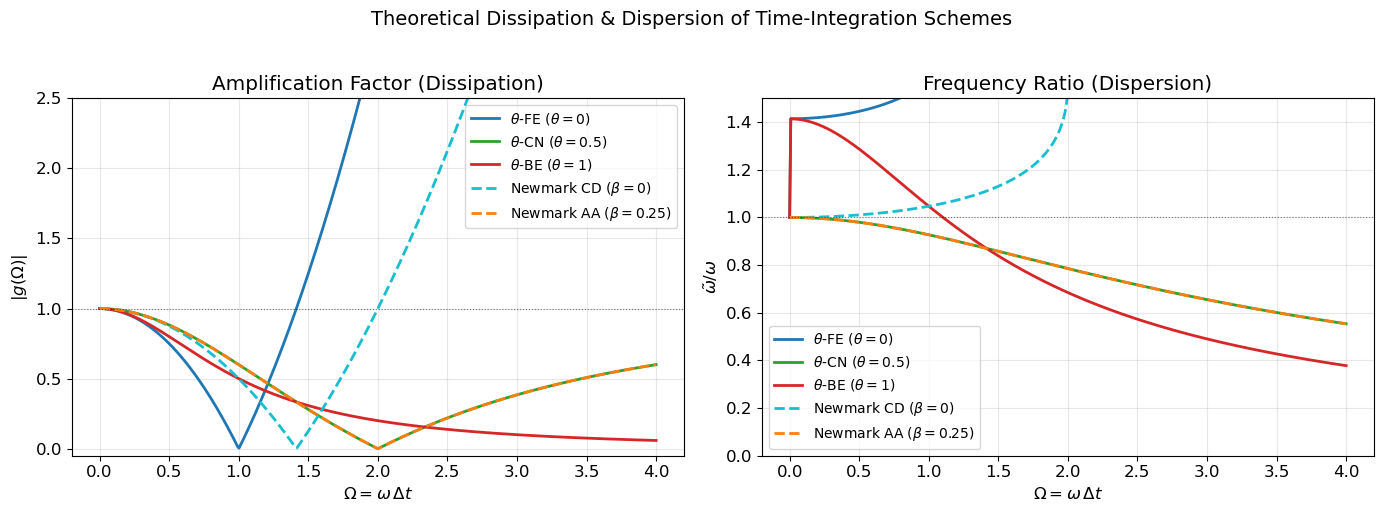

Theoretical plots saved.


In [2]:
# ================================================================
# Theoretical amplification factors
# ================================================================

def g_theta(Omega, theta):
    """Amplification factor for the theta-method on u'' + omega^2 u = 0.
    
    The theta-method recasts the 2nd-order ODE as a 1st-order system
    and applies the theta-rule.  The amplification factor for the
    displacement is:
        g = [1 - (1-theta)^2 * Omega^2] / [1 + theta^2 * Omega^2]
    where Omega = omega * dt.
    """
    return (1.0 - (1.0 - theta)**2 * Omega**2) / (1.0 + theta**2 * Omega**2)


def g_newmark(Omega, beta):
    """Amplification factor for the Newmark method (gamma=0.5).
    
    g = [1 - (0.5 - beta) * Omega^2] / [1 + beta * Omega^2]
    """
    return (1.0 - (0.5 - beta) * Omega**2) / (1.0 + beta * Omega**2)


def numerical_omega_ratio(g_val, Omega):
    """Compute omega_num / omega_exact from the amplification factor.
    
    If g is real and positive, the phase angle is 0 (no oscillation captured).
    For a proper wave, g should be complex or negative.
    
    For a real amplification factor g of the 2nd-order scheme,
    the actual spectral radius involves eigenvalues of the 2x2 amplification
    matrix.  For the wave equation with gamma=0.5 (Newmark) or the 
    theta-method, the eigenvalues are complex conjugate:
        lambda = g_real ± i * sqrt(1 - g_real^2)   when |g_real| <= 1
    so the phase angle per step is arccos(g_real).
    The numerical frequency is then: omega_num = arccos(g) / dt
    => omega_num / omega = arccos(g) / Omega
    """
    g_clamped = np.clip(g_val, -1, 1)
    phase = np.arccos(g_clamped)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where(np.abs(Omega) > 1e-14, phase / Omega, 1.0)
    return ratio


# ----- Plot theoretical amplification factor |g| vs Omega -----
Omega = np.linspace(0, 4, 500)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: |g| (dissipation)
ax = axes[0]
for theta in [0.0, 0.5, 1.0]:
    g = g_theta(Omega, theta)
    label = SCHEME_LABELS[f"theta-{theta:.1f}"]
    color = SCHEME_COLORS[f"theta-{theta:.1f}"]
    ax.plot(Omega, np.abs(g), label=label, color=color, lw=2)

for beta in [0.0, 0.25]:
    g = g_newmark(Omega, beta)
    label = SCHEME_LABELS[f"newmark-{beta:.2f}"]
    color = SCHEME_COLORS[f"newmark-{beta:.2f}"]
    ax.plot(Omega, np.abs(g), label=label, color=color, lw=2, ls="--")

ax.axhline(1.0, color="k", ls=":", lw=0.8, alpha=0.5)
ax.set_xlabel(r"$\Omega = \omega\,\Delta t$")
ax.set_ylabel(r"$|g(\Omega)|$")
ax.set_title("Amplification Factor (Dissipation)")
ax.set_ylim(-0.05, 2.5)
ax.legend(fontsize=10)

# Right: omega_num / omega (dispersion)
ax = axes[1]
for theta in [0.0, 0.5, 1.0]:
    g = g_theta(Omega, theta)
    ratio = numerical_omega_ratio(g, Omega)
    label = SCHEME_LABELS[f"theta-{theta:.1f}"]
    color = SCHEME_COLORS[f"theta-{theta:.1f}"]
    # Only plot where |g| <= 1 (stable region)
    mask = np.abs(g) <= 1.0
    ax.plot(Omega[mask], ratio[mask], label=label, color=color, lw=2)

for beta in [0.0, 0.25]:
    g = g_newmark(Omega, beta)
    ratio = numerical_omega_ratio(g, Omega)
    label = SCHEME_LABELS[f"newmark-{beta:.2f}"]
    color = SCHEME_COLORS[f"newmark-{beta:.2f}"]
    mask = np.abs(g) <= 1.0
    ax.plot(Omega[mask], ratio[mask], label=label, color=color, lw=2, ls="--")

ax.axhline(1.0, color="k", ls=":", lw=0.8, alpha=0.5)
ax.set_xlabel(r"$\Omega = \omega\,\Delta t$")
ax.set_ylabel(r"$\tilde\omega / \omega$")
ax.set_title("Frequency Ratio (Dispersion)")
ax.set_ylim(0.0, 1.5)
ax.legend(fontsize=10)

fig.suptitle("Theoretical Dissipation & Dispersion of Time-Integration Schemes", fontsize=14, y=1.02)
fig.tight_layout()
fig.savefig(FIG_DIR / "theoretical_amplification.pdf", bbox_inches="tight", dpi=150)
fig.savefig(FIG_DIR / "theoretical_amplification.png", bbox_inches="tight", dpi=150)
plt.show()
print("Theoretical plots saved.")

## 2. 2D Stability Maps in $(kh,\, \omega\Delta t)$ Space

We plot the amplification factor $|g|$ and the dispersion ratio $\tilde\omega/\omega$ as heat-maps over the parameter space. This gives a comprehensive picture of where each scheme is accurate and where it becomes unstable or highly dispersive.

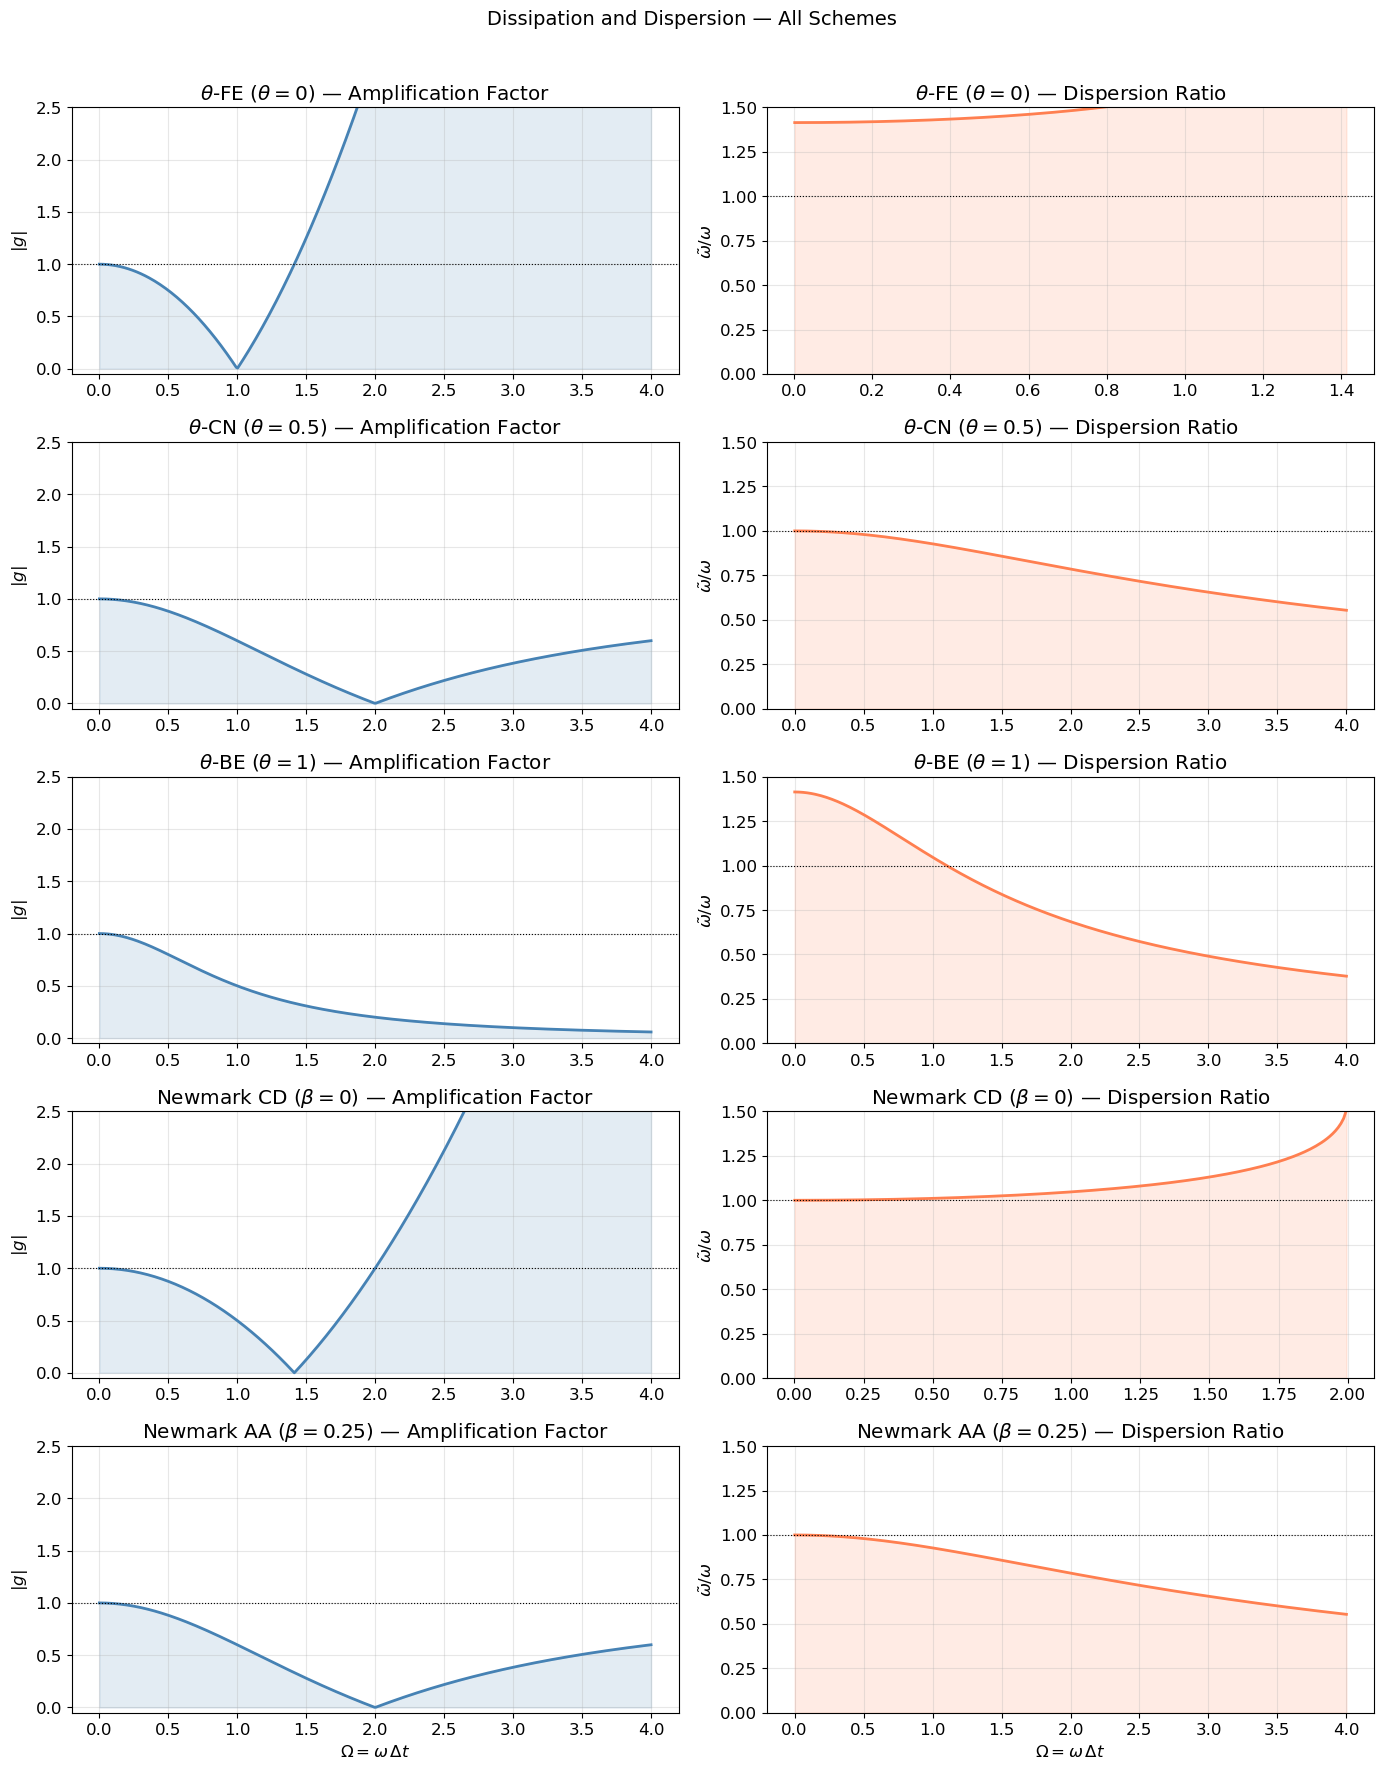

In [3]:
# ================================================================
# 2D contour maps: |g| and omega_num/omega in (Omega) space
# One row per scheme
# ================================================================

schemes_theory = [
    (r"$\theta$-FE ($\theta=0$)",    lambda O: g_theta(O, 0.0)),
    (r"$\theta$-CN ($\theta=0.5$)",  lambda O: g_theta(O, 0.5)),
    (r"$\theta$-BE ($\theta=1$)",    lambda O: g_theta(O, 1.0)),
    (r"Newmark CD ($\beta=0$)",      lambda O: g_newmark(O, 0.0)),
    (r"Newmark AA ($\beta=0.25$)",   lambda O: g_newmark(O, 0.25)),
]

Omega_1d = np.linspace(1e-3, 4.0, 400)

fig, axes = plt.subplots(len(schemes_theory), 2, figsize=(14, 3.5 * len(schemes_theory)))

for row, (name, g_func) in enumerate(schemes_theory):
    g_vals = g_func(Omega_1d)
    abs_g = np.abs(g_vals)
    disp = numerical_omega_ratio(g_vals, Omega_1d)

    # Dissipation: |g|
    ax = axes[row, 0]
    ax.plot(Omega_1d, abs_g, lw=2, color="steelblue")
    ax.fill_between(Omega_1d, 0, abs_g, alpha=0.15, color="steelblue")
    ax.axhline(1, color="k", ls=":", lw=0.8)
    ax.set_ylabel(r"$|g|$")
    ax.set_title(f"{name} — Amplification Factor")
    ax.set_ylim(-0.05, 2.5)
    if row == len(schemes_theory) - 1:
        ax.set_xlabel(r"$\Omega = \omega\,\Delta t$")

    # Dispersion: omega_num/omega
    ax = axes[row, 1]
    mask = abs_g <= 1.0
    ax.plot(Omega_1d[mask], disp[mask], lw=2, color="coral")
    ax.fill_between(Omega_1d[mask], 0, disp[mask], alpha=0.15, color="coral")
    ax.axhline(1, color="k", ls=":", lw=0.8)
    ax.set_ylabel(r"$\tilde\omega / \omega$")
    ax.set_title(f"{name} — Dispersion Ratio")
    ax.set_ylim(0.0, 1.5)
    if row == len(schemes_theory) - 1:
        ax.set_xlabel(r"$\Omega = \omega\,\Delta t$")

fig.suptitle("Dissipation and Dispersion — All Schemes", fontsize=14, y=1.01)
fig.tight_layout()
fig.savefig(FIG_DIR / "all_schemes_1d.pdf", bbox_inches="tight", dpi=150)
fig.savefig(FIG_DIR / "all_schemes_1d.png", bbox_inches="tight", dpi=150)
plt.show()

## 3. Load Simulation Data

We load the results produced by `scripts/dissipation_dispersion_sweep.py`.

The sweep generates:
- **`dissdisp-results.csv`** — one row per (scheme, dt) with summary metrics
- **`dissdisp-energy-series/`** — per-run energy time-series `E(t)`
- **`dissdisp-error-series/`** — per-run relative L2 error time-series

> **If you haven't run the sweep yet**, execute from `wave-equation/scripts/`:
> ```bash
> cd ../scripts && python3 dissipation_dispersion_sweep.py --nprocs 4
> ```

In [4]:
# ================================================================
# Load summary results
# ================================================================

# Look for the results in the scripts/ directory (where the sweep runs)
summary_candidates = sorted(SCRIPT_DIR.glob("dissdisp-results*.csv"))
if not summary_candidates:
    raise FileNotFoundError(
        "No dissdisp-results*.csv found. Run the sweep first:\n"
        "  cd ../scripts && python3 dissipation_dispersion_sweep.py --nprocs 4"
    )

summary_file = summary_candidates[-1]  # take the latest
print(f"Loading summary: {summary_file}")
df = pd.read_csv(summary_file)
print(f"  {len(df)} rows, schemes: {df['scheme'].unique().tolist()}")
print(f"  dt values: {sorted(df['dt'].unique())}")
df.head(10)

Loading summary: /home/ghi/Documents/HPC-PoliMi/NMPDE/labs/wave-equation/scripts/dissdisp-results.csv
  14 rows, schemes: ['theta-0.0', 'theta-0.5', 'theta-1.0', 'newmark-0.00', 'newmark-0.25']
  dt values: [np.float64(0.01), np.float64(0.02), np.float64(0.05), np.float64(0.1)]


,scheme,Nel,R,dt,T,energy_ratio,energy_decay_rate,max_rel_L2,final_rel_L2,final_rel_H1
0,theta-0.0,40,1,0.01,5.0,3.956682e+255,-1.022398e+255,inf,NaN,NaN
1,theta-0.5,40,1,0.10,5.0,1.000000e+00,0.000000e+00,18.156870,0.206598,0.211708
2,theta-0.5,40,1,0.05,5.0,1.000000e+00,0.000000e+00,4.009166,0.031720,0.050686
3,theta-0.5,40,1,0.02,5.0,1.000000e+00,0.000000e+00,0.199512,0.002116,0.038306
4,theta-0.5,40,1,0.01,5.0,1.000000e+00,0.000000e+00,2.580382,0.004927,0.038451
5,theta-1.0,40,1,0.10,5.0,1.209649e-04,1.960547e-01,1.860014,0.989852,0.989853
6,theta-1.0,40,1,0.05,5.0,8.033311e-03,1.964290e-01,2.865046,0.903665,0.903672
7,theta-1.0,40,1,0.02,5.0,1.395700e-01,1.714004e-01,2.225301,0.623618,0.623785
8,theta-1.0,40,1,0.01,5.0,3.725036e-01,1.252488e-01,0.417914,0.391318,0.392012
9,newmark-0.00,40,1,0.01,5.0,6.628969e+133,-1.323148e+133,inf,NaN,NaN


In [5]:
# ================================================================
# Load per-run energy, error, and probe time-series
# ================================================================

energy_dirs = sorted(SCRIPT_DIR.glob("dissdisp-energy-series*"))
error_dirs  = sorted(SCRIPT_DIR.glob("dissdisp-error-series*"))
probe_dirs  = sorted(SCRIPT_DIR.glob("dissdisp-probe-series*"))

energy_series = {}  # key: (scheme, dt) -> DataFrame(time, energy)
error_series  = {}  # key: (scheme, dt) -> DataFrame(time, rel_L2_error)
probe_series  = {}  # key: (scheme, dt) -> DataFrame(time, u_probe)

if energy_dirs:
    edir = energy_dirs[-1]
    for f in sorted(edir.glob("*.csv")):
        # filename: theta-0.5_dt0.005.csv
        parts = f.stem.split("_dt")
        if len(parts) == 2:
            scheme = parts[0]
            dt_val = float(parts[1])
            energy_series[(scheme, dt_val)] = pd.read_csv(f)
    print(f"Loaded {len(energy_series)} energy time-series from {edir.name}")
else:
    print("WARNING: No energy time-series directory found.")

if error_dirs:
    edir = error_dirs[-1]
    for f in sorted(edir.glob("*.csv")):
        parts = f.stem.split("_dt")
        if len(parts) == 2:
            scheme = parts[0]
            dt_val = float(parts[1])
            error_series[(scheme, dt_val)] = pd.read_csv(f)
    print(f"Loaded {len(error_series)} error time-series from {edir.name}")
else:
    print("WARNING: No error time-series directory found.")

if probe_dirs:
    pdir = probe_dirs[-1]
    for f in sorted(pdir.glob("*.csv")):
        parts = f.stem.split("_dt")
        if len(parts) == 2:
            scheme = parts[0]
            dt_val = float(parts[1])
            probe_series[(scheme, dt_val)] = pd.read_csv(f)
    print(f"Loaded {len(probe_series)} probe time-series from {pdir.name}")
else:
    print("WARNING: No probe time-series directory found. Rebuild + re-run sweep to generate probe.csv.")

Loaded 24 energy time-series from dissdisp-energy-series
Loaded 24 error time-series from dissdisp-error-series
Loaded 14 probe time-series from dissdisp-probe-series


## 4. Dissipation Analysis — Energy Evolution

For a non-dissipative scheme the discrete energy $E^n = \tfrac12(\mathbf{v}^T M \mathbf{v} + \mathbf{u}^T K \mathbf{u})$ should remain constant. Any decay indicates numerical dissipation.

We expect:
- **θ = 0.5** (CN) and **β = 0.25** (AA): energy-conserving → $E(T)/E(0) = 1$
- **θ = 1** (BE): strong energy decay
- **θ = 0** (FE) and **β = 0** (CD): energy growth (anti-dissipation) → unstable if CFL violated

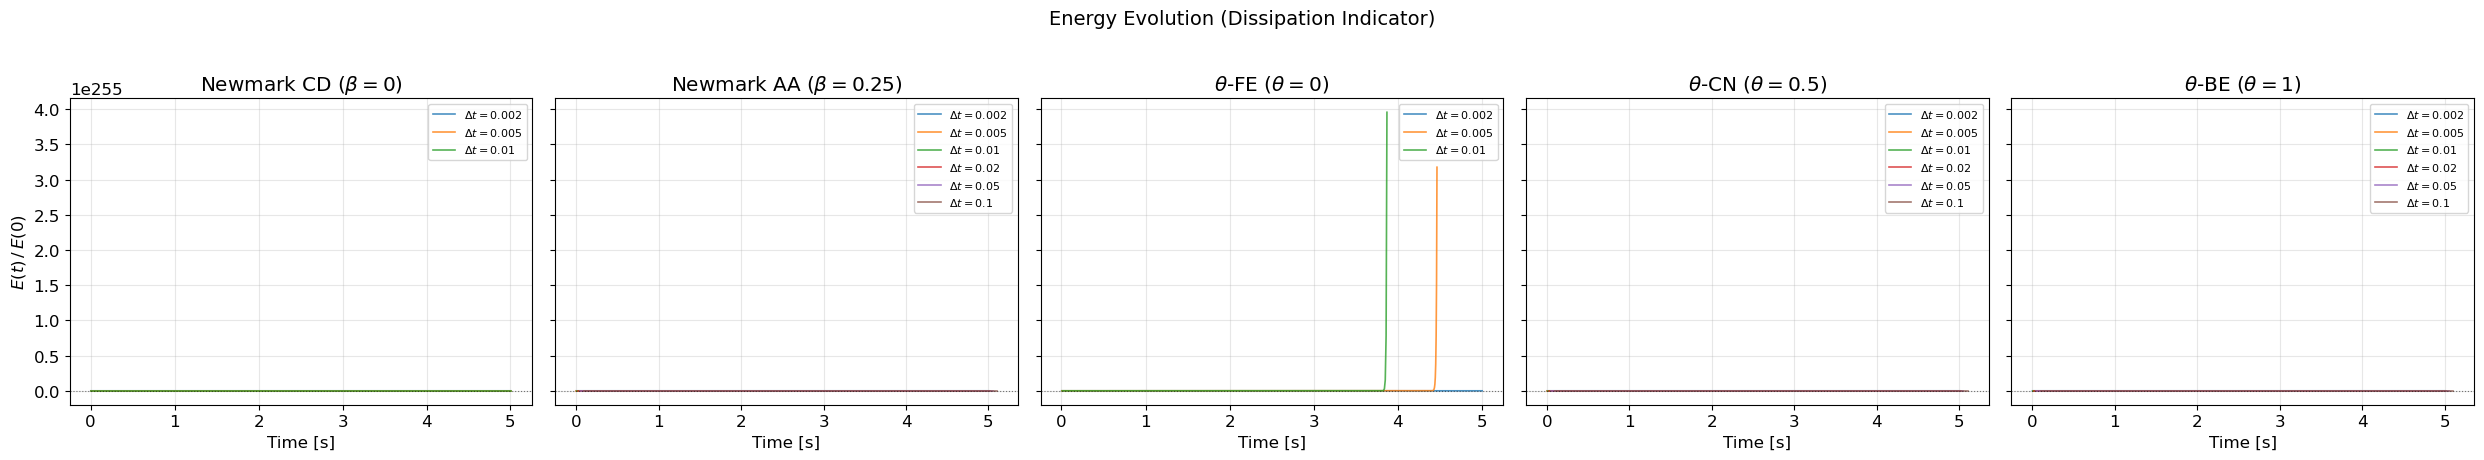

In [6]:
# ================================================================
# Plot: Normalised energy E(t)/E(0) vs time  — one subplot per scheme
# ================================================================

if energy_series:
    schemes_present = sorted(set(k[0] for k in energy_series))
    n_schemes = len(schemes_present)
    fig, axes = plt.subplots(1, n_schemes, figsize=(5 * n_schemes, 4.5), sharey=True)
    if n_schemes == 1:
        axes = [axes]

    for ax, scheme in zip(axes, schemes_present):
        dt_keys = sorted([k for k in energy_series if k[0] == scheme], key=lambda x: x[1])
        color = SCHEME_COLORS.get(scheme, "gray")
        for key in dt_keys:
            edf = energy_series[key]
            E0 = edf["energy"].iloc[0]
            if E0 > 0:
                ax.plot(edf["time"], edf["energy"] / E0,
                        label=rf"$\Delta t = {key[1]}$", alpha=0.8, lw=1.2)
        ax.axhline(1.0, color="k", ls=":", lw=0.8, alpha=0.5)
        ax.set_xlabel("Time [s]")
        ax.set_title(SCHEME_LABELS.get(scheme, scheme))
        ax.legend(fontsize=8)
    axes[0].set_ylabel(r"$E(t) \, / \, E(0)$")

    fig.suptitle("Energy Evolution (Dissipation Indicator)", fontsize=14, y=1.02)
    fig.tight_layout()
    fig.savefig(FIG_DIR / "energy_evolution.pdf", bbox_inches="tight", dpi=150)
    fig.savefig(FIG_DIR / "energy_evolution.png", bbox_inches="tight", dpi=150)
    plt.show()
else:
    print("No energy time-series data available. Run the sweep first.")

## 5. Measured vs Theoretical Dissipation

We compare the **measured per-step amplification factor** (extracted from $E(T)/E(0)$) with the theoretical prediction.

For a single mode with $N$ time steps:
$$|g|^{2N} = \frac{E(T)}{E(0)} \quad\Longrightarrow\quad |g|_{\text{measured}} = \left(\frac{E(T)}{E(0)}\right)^{1/(2N)}$$

We compare this with $|g(\Omega)|$ where $\Omega = \omega_{\text{exact}} \cdot \Delta t$.

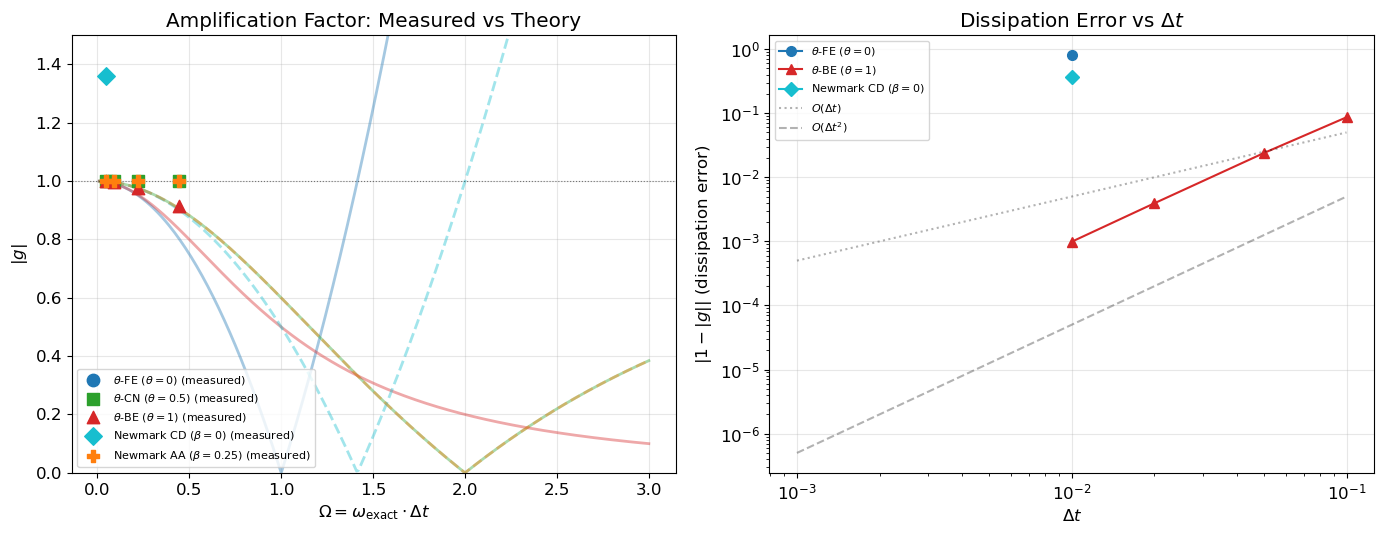

In [7]:
# ================================================================
# Measured |g| vs theoretical |g|
# ================================================================

if not df.empty and "energy_ratio" in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

    # Prepare theoretical curves
    Omega_th = np.linspace(0.01, 3.0, 300)

    # --- Left panel: |g| vs Omega ---
    ax = axes[0]
    for scheme in df["scheme"].unique():
        sub = df[df["scheme"] == scheme].dropna(subset=["energy_ratio"]).copy()
        if sub.empty:
            continue

        color = SCHEME_COLORS.get(scheme, "gray")
        marker = SCHEME_MARKERS.get(scheme, "o")
        label = SCHEME_LABELS.get(scheme, scheme)

        # Measured |g| from energy ratio
        T_val = sub["T"].iloc[0]
        sub["Omega"] = OMEGA_EXACT * sub["dt"]
        sub["N_steps"] = (T_val / sub["dt"]).astype(int)
        sub["g_measured"] = sub.apply(
            lambda r: np.abs(r["energy_ratio"])**(1.0 / (2.0 * r["N_steps"]))
            if r["energy_ratio"] > 0 else np.nan, axis=1
        )

        # Plot measured
        ax.scatter(sub["Omega"], sub["g_measured"], color=color, marker=marker,
                   s=80, zorder=5, label=f"{label} (measured)")

    # Plot theoretical curves
    for theta in [0.0, 0.5, 1.0]:
        g_th = np.abs(g_theta(Omega_th, theta))
        color = SCHEME_COLORS[f"theta-{theta:.1f}"]
        ax.plot(Omega_th, g_th, color=color, alpha=0.4, lw=2, ls="-")

    for beta in [0.0, 0.25]:
        g_th = np.abs(g_newmark(Omega_th, beta))
        color = SCHEME_COLORS[f"newmark-{beta:.2f}"]
        ax.plot(Omega_th, g_th, color=color, alpha=0.4, lw=2, ls="--")

    ax.axhline(1.0, color="k", ls=":", lw=0.8, alpha=0.5)
    ax.set_xlabel(r"$\Omega = \omega_{\mathrm{exact}} \cdot \Delta t$")
    ax.set_ylabel(r"$|g|$")
    ax.set_title("Amplification Factor: Measured vs Theory")
    ax.set_ylim(0.0, 1.5)
    ax.legend(fontsize=8, loc="lower left")

    # --- Right panel: |1 - |g|| vs dt (log-log) ---
    ax = axes[1]
    for scheme in df["scheme"].unique():
        sub = df[df["scheme"] == scheme].dropna(subset=["energy_ratio"]).copy()
        if sub.empty:
            continue

        color = SCHEME_COLORS.get(scheme, "gray")
        marker = SCHEME_MARKERS.get(scheme, "o")
        label = SCHEME_LABELS.get(scheme, scheme)

        T_val = sub["T"].iloc[0]
        sub["N_steps"] = (T_val / sub["dt"]).astype(int)
        sub["g_measured"] = sub.apply(
            lambda r: np.abs(r["energy_ratio"])**(1.0 / (2.0 * r["N_steps"]))
            if r["energy_ratio"] > 0 else np.nan, axis=1
        )
        sub["diss_error"] = np.abs(1.0 - sub["g_measured"])
        sub = sub[sub["diss_error"] > 1e-15]  # skip exact-zero for log scale

        if not sub.empty:
            ax.loglog(sub["dt"], sub["diss_error"], marker=marker, color=color,
                      label=label, lw=1.5, markersize=7)

    # Reference slopes
    dt_ref = np.array([1e-3, 1e-1])
    ax.loglog(dt_ref, 5e-1 * dt_ref**1, "k:", alpha=0.3, label=r"$O(\Delta t)$")
    ax.loglog(dt_ref, 5e-1 * dt_ref**2, "k--", alpha=0.3, label=r"$O(\Delta t^2)$")

    ax.set_xlabel(r"$\Delta t$")
    ax.set_ylabel(r"$|1 - |g||$ (dissipation error)")
    ax.set_title(r"Dissipation Error vs $\Delta t$")
    ax.legend(fontsize=8)

    fig.tight_layout()
    fig.savefig(FIG_DIR / "measured_vs_theoretical_dissipation.pdf", bbox_inches="tight", dpi=150)
    fig.savefig(FIG_DIR / "measured_vs_theoretical_dissipation.png", bbox_inches="tight", dpi=150)
    plt.show()
else:
    print("No energy_ratio data available.")

## 6. Dispersion Analysis — Point Probe vs Exact Solution

The most direct way to *see* dispersion is to overlay the **numerical solution at the domain centre** $(0.5, 0.5)$ with the **exact solution**:

$$u_{\text{exact}}(0.5,\,0.5,\,t) = \cos\!\bigl(\sqrt{2}\,\pi\,t\bigr)$$

since $\sin(\pi/2) = 1$.  A **dispersive** scheme produces a cosine with a slightly wrong frequency $\tilde\omega \neq \omega$, so the two curves gradually **drift out of phase**.  A **dissipative** scheme also shows **amplitude decay** on top of the phase shift.

If no probe data is available yet, we fall back to the $L^2$ error time-series.

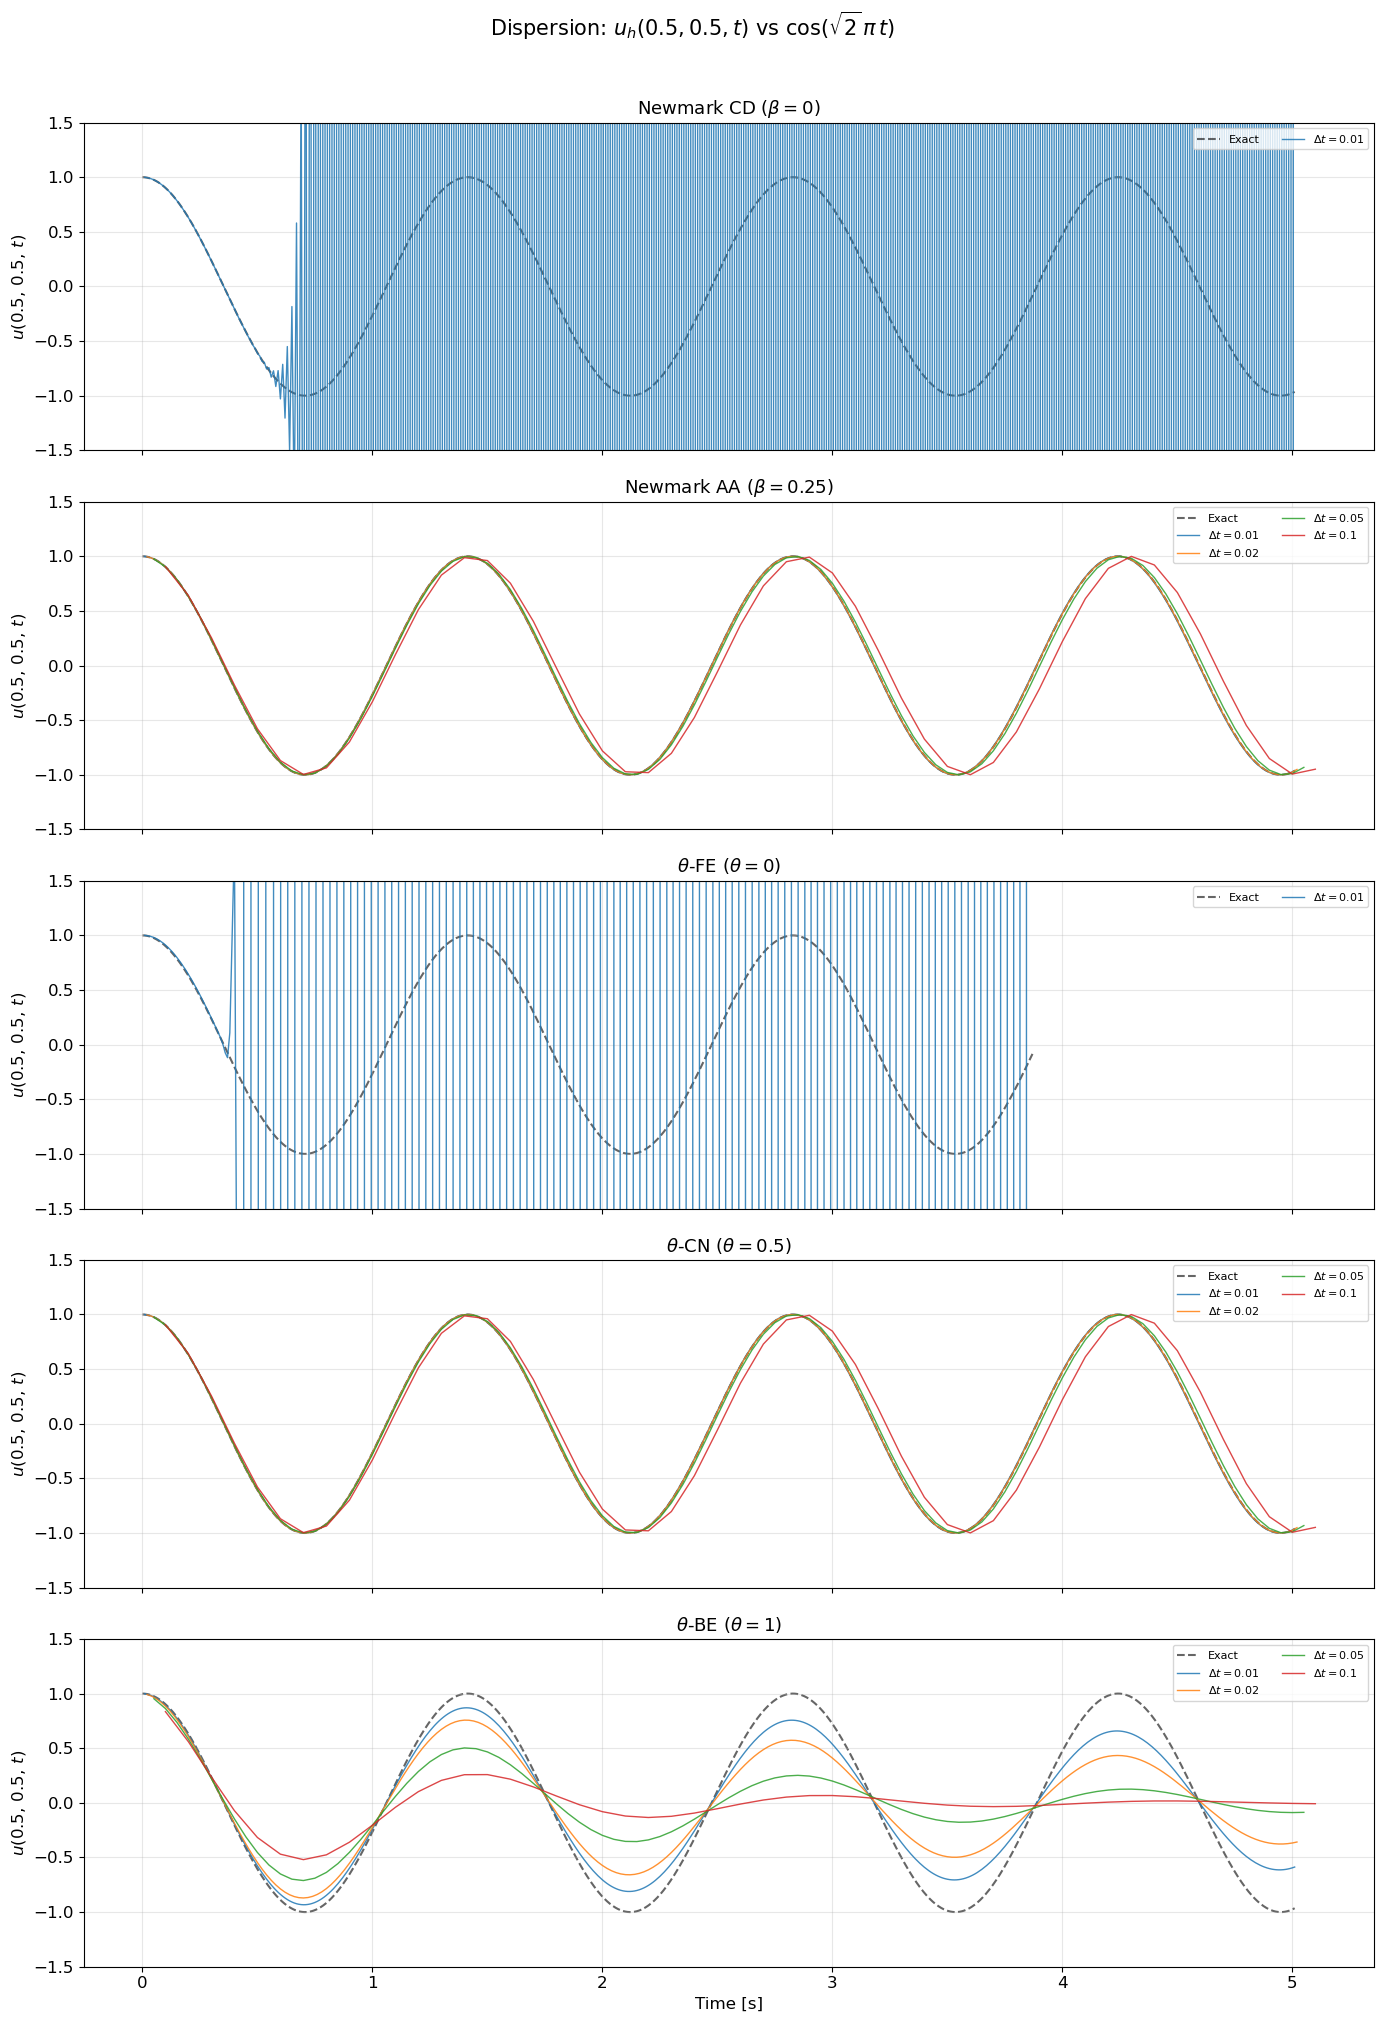

In [8]:
# ================================================================
# Plot: u(0.5, 0.5, t) numerical vs exact — one subplot per scheme
# ================================================================

if probe_series:
    schemes_present = sorted(set(k[0] for k in probe_series))
    n_schemes = len(schemes_present)
    fig, axes = plt.subplots(n_schemes, 1, figsize=(14, 4 * n_schemes), sharex=True)
    if n_schemes == 1:
        axes = [axes]

    for ax, scheme in zip(axes, schemes_present):
        dt_keys = sorted([k for k in probe_series if k[0] == scheme], key=lambda x: x[1])

        # Plot exact solution as dashed black line
        t_fine = np.linspace(0, probe_series[dt_keys[0]]["time"].iloc[-1], 2000)
        u_exact = np.cos(OMEGA_EXACT * t_fine)
        ax.plot(t_fine, u_exact, "k--", lw=1.5, alpha=0.6, label="Exact", zorder=0)

        # Overlay numerical for each dt
        for key in dt_keys:
            pdf = probe_series[key]
            ax.plot(pdf["time"], pdf["u_probe"],
                    label=rf"$\Delta t = {key[1]}$", alpha=0.85, lw=1.0)

        ax.set_ylabel(r"$u(0.5,\,0.5,\,t)$")
        ax.set_title(SCHEME_LABELS.get(scheme, scheme), fontsize=13)
        ax.legend(fontsize=8, loc="upper right", ncol=2)
        ax.set_ylim(-1.5, 1.5)

    axes[-1].set_xlabel("Time [s]")
    fig.suptitle(r"Dispersion: $u_h(0.5,0.5,t)$ vs $\cos(\sqrt{2}\,\pi\,t)$",
                 fontsize=15, y=1.01)
    fig.tight_layout()
    fig.savefig(FIG_DIR / "probe_vs_exact.pdf", bbox_inches="tight", dpi=150)
    fig.savefig(FIG_DIR / "probe_vs_exact.png", bbox_inches="tight", dpi=150)
    plt.show()

elif error_series:
    # Fallback: show L2 error evolution (old approach)
    schemes_present = sorted(set(k[0] for k in error_series))
    n_schemes = len(schemes_present)
    fig, axes = plt.subplots(1, n_schemes, figsize=(5 * n_schemes, 4.5), sharey=True)
    if n_schemes == 1:
        axes = [axes]
    for ax, scheme in zip(axes, schemes_present):
        dt_keys = sorted([k for k in error_series if k[0] == scheme], key=lambda x: x[1])
        for key in dt_keys:
            edf = error_series[key]
            ax.plot(edf["time"], edf["rel_L2_error"],
                    label=rf"$\Delta t = {key[1]}$", alpha=0.8, lw=1.0)
        ax.set_xlabel("Time [s]")
        ax.set_title(SCHEME_LABELS.get(scheme, scheme))
        ax.legend(fontsize=7)
        ax.set_yscale("log")
    axes[0].set_ylabel(r"Relative $L^2$ error")
    fig.suptitle(r"$L^2$ Error Evolution (no probe data yet — run sweep after rebuild)",
                 fontsize=14, y=1.02)
    fig.tight_layout()
    plt.show()
else:
    print("No probe or error time-series data available.")

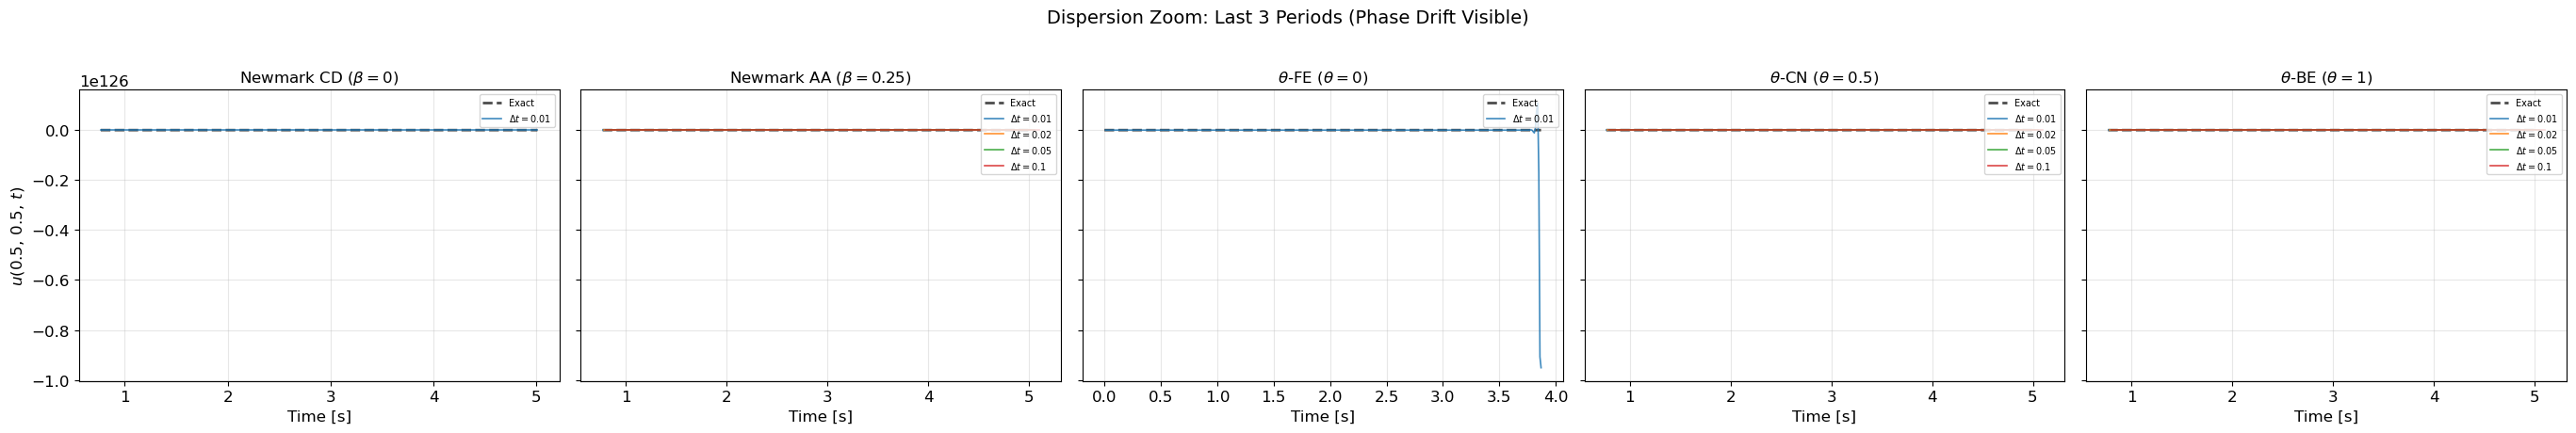

In [9]:
# ================================================================
# Zoomed view: last few periods — phase drift is most visible here
# ================================================================

if probe_series:
    schemes_present = sorted(set(k[0] for k in probe_series))
    n_schemes = len(schemes_present)

    # Exact period = 2*pi / omega = 2*pi / (sqrt(2)*pi) = sqrt(2) ≈ 1.414 s
    T_period = 2.0 * np.pi / OMEGA_EXACT

    fig, axes = plt.subplots(1, n_schemes, figsize=(5.5 * n_schemes, 4.5), sharey=True)
    if n_schemes == 1:
        axes = [axes]

    for ax, scheme in zip(axes, schemes_present):
        dt_keys = sorted([k for k in probe_series if k[0] == scheme], key=lambda x: x[1])
        T_end = probe_series[dt_keys[0]]["time"].iloc[-1]

        # Show last 3 periods
        t_start = max(0.0, T_end - 3.0 * T_period)

        t_fine = np.linspace(t_start, T_end, 2000)
        u_exact = np.cos(OMEGA_EXACT * t_fine)
        ax.plot(t_fine, u_exact, "k--", lw=2.0, alpha=0.7, label="Exact")

        for key in dt_keys:
            pdf = probe_series[key]
            mask = pdf["time"] >= t_start
            ax.plot(pdf.loc[mask, "time"], pdf.loc[mask, "u_probe"],
                    label=rf"$\Delta t = {key[1]}$", alpha=0.85, lw=1.2)

        ax.set_xlabel("Time [s]")
        ax.set_title(SCHEME_LABELS.get(scheme, scheme), fontsize=12)
        ax.legend(fontsize=7, loc="upper right")

    axes[0].set_ylabel(r"$u(0.5,\,0.5,\,t)$")
    fig.suptitle("Dispersion Zoom: Last 3 Periods (Phase Drift Visible)", fontsize=14, y=1.02)
    fig.tight_layout()
    fig.savefig(FIG_DIR / "probe_zoom_last_periods.pdf", bbox_inches="tight", dpi=150)
    fig.savefig(FIG_DIR / "probe_zoom_last_periods.png", bbox_inches="tight", dpi=150)
    plt.show()
else:
    # Fallback: error vs dt (old approach)
    if not df.empty and "final_rel_L2" in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
        ax = axes[0]
        for scheme in df["scheme"].unique():
            sub = df[df["scheme"] == scheme].dropna(subset=["max_rel_L2"]).sort_values("dt")
            if sub.empty: continue
            ax.loglog(sub["dt"], sub["max_rel_L2"],
                      marker=SCHEME_MARKERS.get(scheme, "o"),
                      color=SCHEME_COLORS.get(scheme, "gray"),
                      label=SCHEME_LABELS.get(scheme, scheme), lw=1.5, markersize=7)
        dt_ref = np.array([1e-3, 1e-1])
        ax.loglog(dt_ref, 2 * dt_ref**1, "k:", alpha=0.3, label=r"$O(\Delta t)$")
        ax.loglog(dt_ref, 2 * dt_ref**2, "k--", alpha=0.3, label=r"$O(\Delta t^2)$")
        ax.set_xlabel(r"$\Delta t$"); ax.set_ylabel(r"Max rel. $L^2$ error")
        ax.set_title(r"Max $L^2$ Error vs $\Delta t$"); ax.legend(fontsize=9)

        ax = axes[1]
        for scheme in df["scheme"].unique():
            sub = df[df["scheme"] == scheme].dropna(subset=["final_rel_L2"]).sort_values("dt")
            if sub.empty: continue
            ax.loglog(sub["dt"], sub["final_rel_L2"],
                      marker=SCHEME_MARKERS.get(scheme, "o"),
                      color=SCHEME_COLORS.get(scheme, "gray"),
                      label=SCHEME_LABELS.get(scheme, scheme), lw=1.5, markersize=7)
        ax.loglog(dt_ref, 2 * dt_ref**1, "k:", alpha=0.3, label=r"$O(\Delta t)$")
        ax.loglog(dt_ref, 2 * dt_ref**2, "k--", alpha=0.3, label=r"$O(\Delta t^2)$")
        ax.set_xlabel(r"$\Delta t$"); ax.set_ylabel(r"Final rel. $L^2$ error")
        ax.set_title(r"Final-Time $L^2$ Error vs $\Delta t$"); ax.legend(fontsize=9)
        fig.tight_layout(); plt.show()
    else:
        print("No data available.")

## 7. Quantifying Dispersion: Measured Frequency Shift

We extract the **numerical frequency** $\tilde\omega$ from the probe data by fitting a cosine (or by zero-crossing analysis) and compare with $\omega_{\text{exact}} = \sqrt{2}\,\pi$.

The **relative frequency error** $|\tilde\omega/\omega - 1|$ quantifies dispersion and should converge as $O(\Delta t^2)$ for 2nd-order schemes.

We also keep the theoretical $|g(\Omega)|$ and $\tilde\omega/\omega$ comparison from the amplification factor analysis.

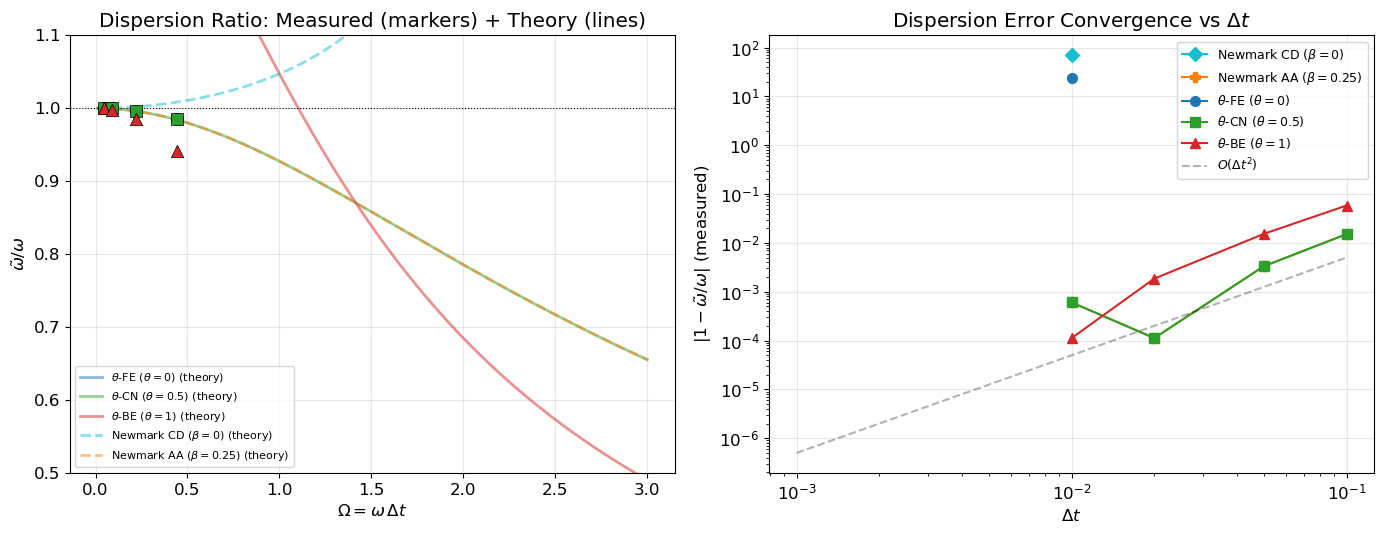


=== Measured frequency ratios ===
      scheme         dt      Omega  omega_ratio_measured  freq_error_measured
newmark-0.00 0.01000000 0.04442883           70.71067811          69.71067811
newmark-0.25 0.01000000 0.04442883            1.00060582           0.00060582
newmark-0.25 0.02000000 0.08885766            1.00011247           0.00011247
newmark-0.25 0.05000000 0.22214415            0.99667767           0.00332233
newmark-0.25 0.10000000 0.44428829            0.98488049           0.01511951
   theta-0.0 0.01000000 0.04442883           24.30887281          23.30887281
   theta-0.5 0.01000000 0.04442883            1.00060582           0.00060582
   theta-0.5 0.02000000 0.08885766            1.00011247           0.00011247
   theta-0.5 0.05000000 0.22214415            0.99667767           0.00332233
   theta-0.5 0.10000000 0.44428829            0.98488049           0.01511951
   theta-1.0 0.01000000 0.04442883            1.00011215           0.00011215
   theta-1.0 0.02000000 0.088

In [10]:
# ================================================================
# Measure numerical frequency from probe data via zero-crossing analysis
# Compare with theoretical omega_ratio from amplification factor
# ================================================================

def estimate_omega_from_zero_crossings(t, u):
    """Estimate angular frequency from zero-crossings of a signal.
    Returns omega estimate."""
    # Find zero crossings (sign changes)
    sign_changes = np.where(np.diff(np.sign(u)))[0]
    if len(sign_changes) < 4:
        return np.nan
    # Linear interpolation for exact crossing times
    crossing_times = []
    for i in sign_changes:
        t0, t1 = t[i], t[i + 1]
        u0, u1 = u[i], u[i + 1]
        if u1 != u0:
            t_cross = t0 - u0 * (t1 - t0) / (u1 - u0)
            crossing_times.append(t_cross)
    crossing_times = np.array(crossing_times)
    if len(crossing_times) < 4:
        return np.nan
    # Period = 2 * (average half-period)
    half_periods = np.diff(crossing_times)
    period = 2.0 * np.median(half_periods)
    return 2.0 * np.pi / period

# Build analysis table combining measured (probe) + theoretical
rows = []

if probe_series:
    for (scheme, dt_val), pdf in probe_series.items():
        t = pdf["time"].values
        u = pdf["u_probe"].values
        omega_meas = estimate_omega_from_zero_crossings(t, u)
        omega_ratio_meas = omega_meas / OMEGA_EXACT if not np.isnan(omega_meas) else np.nan
        Omega = OMEGA_EXACT * dt_val
        rows.append({
            "scheme": scheme, "dt": dt_val, "Omega": Omega,
            "omega_ratio_measured": omega_ratio_meas,
            "freq_error_measured": abs(1.0 - omega_ratio_meas) if not np.isnan(omega_ratio_meas) else np.nan,
        })

if rows:
    df_freq = pd.DataFrame(rows)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

    # Left: omega_ratio vs Omega (measured points + theoretical curves)
    ax = axes[0]
    Omega_th = np.linspace(0.01, 3.0, 300)
    for theta in [0.0, 0.5, 1.0]:
        g_vals = g_theta(Omega_th, theta)
        ratio = numerical_omega_ratio(g_vals, Omega_th)
        mask_stable = np.abs(g_vals) <= 1.0
        ax.plot(Omega_th[mask_stable], ratio[mask_stable],
                color=SCHEME_COLORS[f"theta-{theta:.1f}"], lw=2, alpha=0.5,
                label=SCHEME_LABELS[f"theta-{theta:.1f}"] + " (theory)")
    for beta in [0.0, 0.25]:
        g_vals = g_newmark(Omega_th, beta)
        ratio = numerical_omega_ratio(g_vals, Omega_th)
        mask_stable = np.abs(g_vals) <= 1.0
        ax.plot(Omega_th[mask_stable], ratio[mask_stable],
                color=SCHEME_COLORS[f"newmark-{beta:.2f}"], lw=2, alpha=0.5, ls="--",
                label=SCHEME_LABELS[f"newmark-{beta:.2f}"] + " (theory)")

    # Overlay measured points
    for scheme in df_freq["scheme"].unique():
        sub = df_freq[df_freq["scheme"] == scheme].dropna(subset=["omega_ratio_measured"])
        if sub.empty: continue
        ax.scatter(sub["Omega"], sub["omega_ratio_measured"],
                   color=SCHEME_COLORS.get(scheme, "gray"),
                   marker=SCHEME_MARKERS.get(scheme, "o"), s=80, zorder=5,
                   edgecolors="k", linewidths=0.5)

    ax.axhline(1.0, color="k", ls=":", lw=0.8)
    ax.set_xlabel(r"$\Omega = \omega\,\Delta t$")
    ax.set_ylabel(r"$\tilde\omega / \omega$")
    ax.set_title("Dispersion Ratio: Measured (markers) + Theory (lines)")
    ax.set_ylim(0.5, 1.1)
    ax.legend(fontsize=8)

    # Right: |1 - omega_ratio| vs dt (convergence)
    ax = axes[1]
    for scheme in df_freq["scheme"].unique():
        sub = df_freq[df_freq["scheme"] == scheme].dropna(subset=["freq_error_measured"])
        sub = sub[sub["freq_error_measured"] > 1e-15].sort_values("dt")
        if sub.empty: continue
        ax.loglog(sub["dt"], sub["freq_error_measured"],
                  marker=SCHEME_MARKERS.get(scheme, "o"),
                  color=SCHEME_COLORS.get(scheme, "gray"),
                  label=SCHEME_LABELS.get(scheme, scheme), lw=1.5, markersize=7)

    dt_ref = np.array([1e-3, 1e-1])
    ax.loglog(dt_ref, 0.5 * dt_ref**2, "k--", alpha=0.3, label=r"$O(\Delta t^2)$")
    ax.set_xlabel(r"$\Delta t$")
    ax.set_ylabel(r"$|1 - \tilde\omega/\omega|$ (measured)")
    ax.set_title(r"Dispersion Error Convergence vs $\Delta t$")
    ax.legend(fontsize=9)

    fig.tight_layout()
    fig.savefig(FIG_DIR / "dispersion_measured_frequency.pdf", bbox_inches="tight", dpi=150)
    fig.savefig(FIG_DIR / "dispersion_measured_frequency.png", bbox_inches="tight", dpi=150)
    plt.show()

    print("\n=== Measured frequency ratios ===")
    print(df_freq[["scheme", "dt", "Omega", "omega_ratio_measured", "freq_error_measured"]]
          .to_string(index=False, float_format="{:.8f}".format))
else:
    # No probe data: fall back to purely theoretical omega analysis
    print("No probe data yet. Showing theoretical dispersion curves only.")
    fig, ax = plt.subplots(figsize=(8, 5))
    Omega_th = np.linspace(0.01, 3.0, 300)
    for theta in [0.0, 0.5, 1.0]:
        g_vals = g_theta(Omega_th, theta)
        ratio = numerical_omega_ratio(g_vals, Omega_th)
        mask_stable = np.abs(g_vals) <= 1.0
        ax.plot(Omega_th[mask_stable], ratio[mask_stable],
                color=SCHEME_COLORS[f"theta-{theta:.1f}"], lw=2,
                label=SCHEME_LABELS[f"theta-{theta:.1f}"])
    for beta in [0.0, 0.25]:
        g_vals = g_newmark(Omega_th, beta)
        ratio = numerical_omega_ratio(g_vals, Omega_th)
        mask_stable = np.abs(g_vals) <= 1.0
        ax.plot(Omega_th[mask_stable], ratio[mask_stable],
                color=SCHEME_COLORS[f"newmark-{beta:.2f}"], lw=2, ls="--",
                label=SCHEME_LABELS[f"newmark-{beta:.2f}"])
    ax.axhline(1.0, color="k", ls=":", lw=0.8)
    ax.set_xlabel(r"$\Omega = \omega\,\Delta t$")
    ax.set_ylabel(r"$\tilde\omega/\omega$")
    ax.set_title("Theoretical Dispersion Ratio")
    ax.set_ylim(0.5, 1.1)
    ax.legend()
    fig.tight_layout()
    plt.show()

## 8. Side-by-Side: Dissipation (Energy) + Dispersion (Probe)

One figure per scheme showing **energy** $E(t)/E(0)$ on the left and **probe** $u_h(0.5,0.5,t)$ on the right, for a single representative $\Delta t$.  This gives the clearest visual of how each scheme behaves.

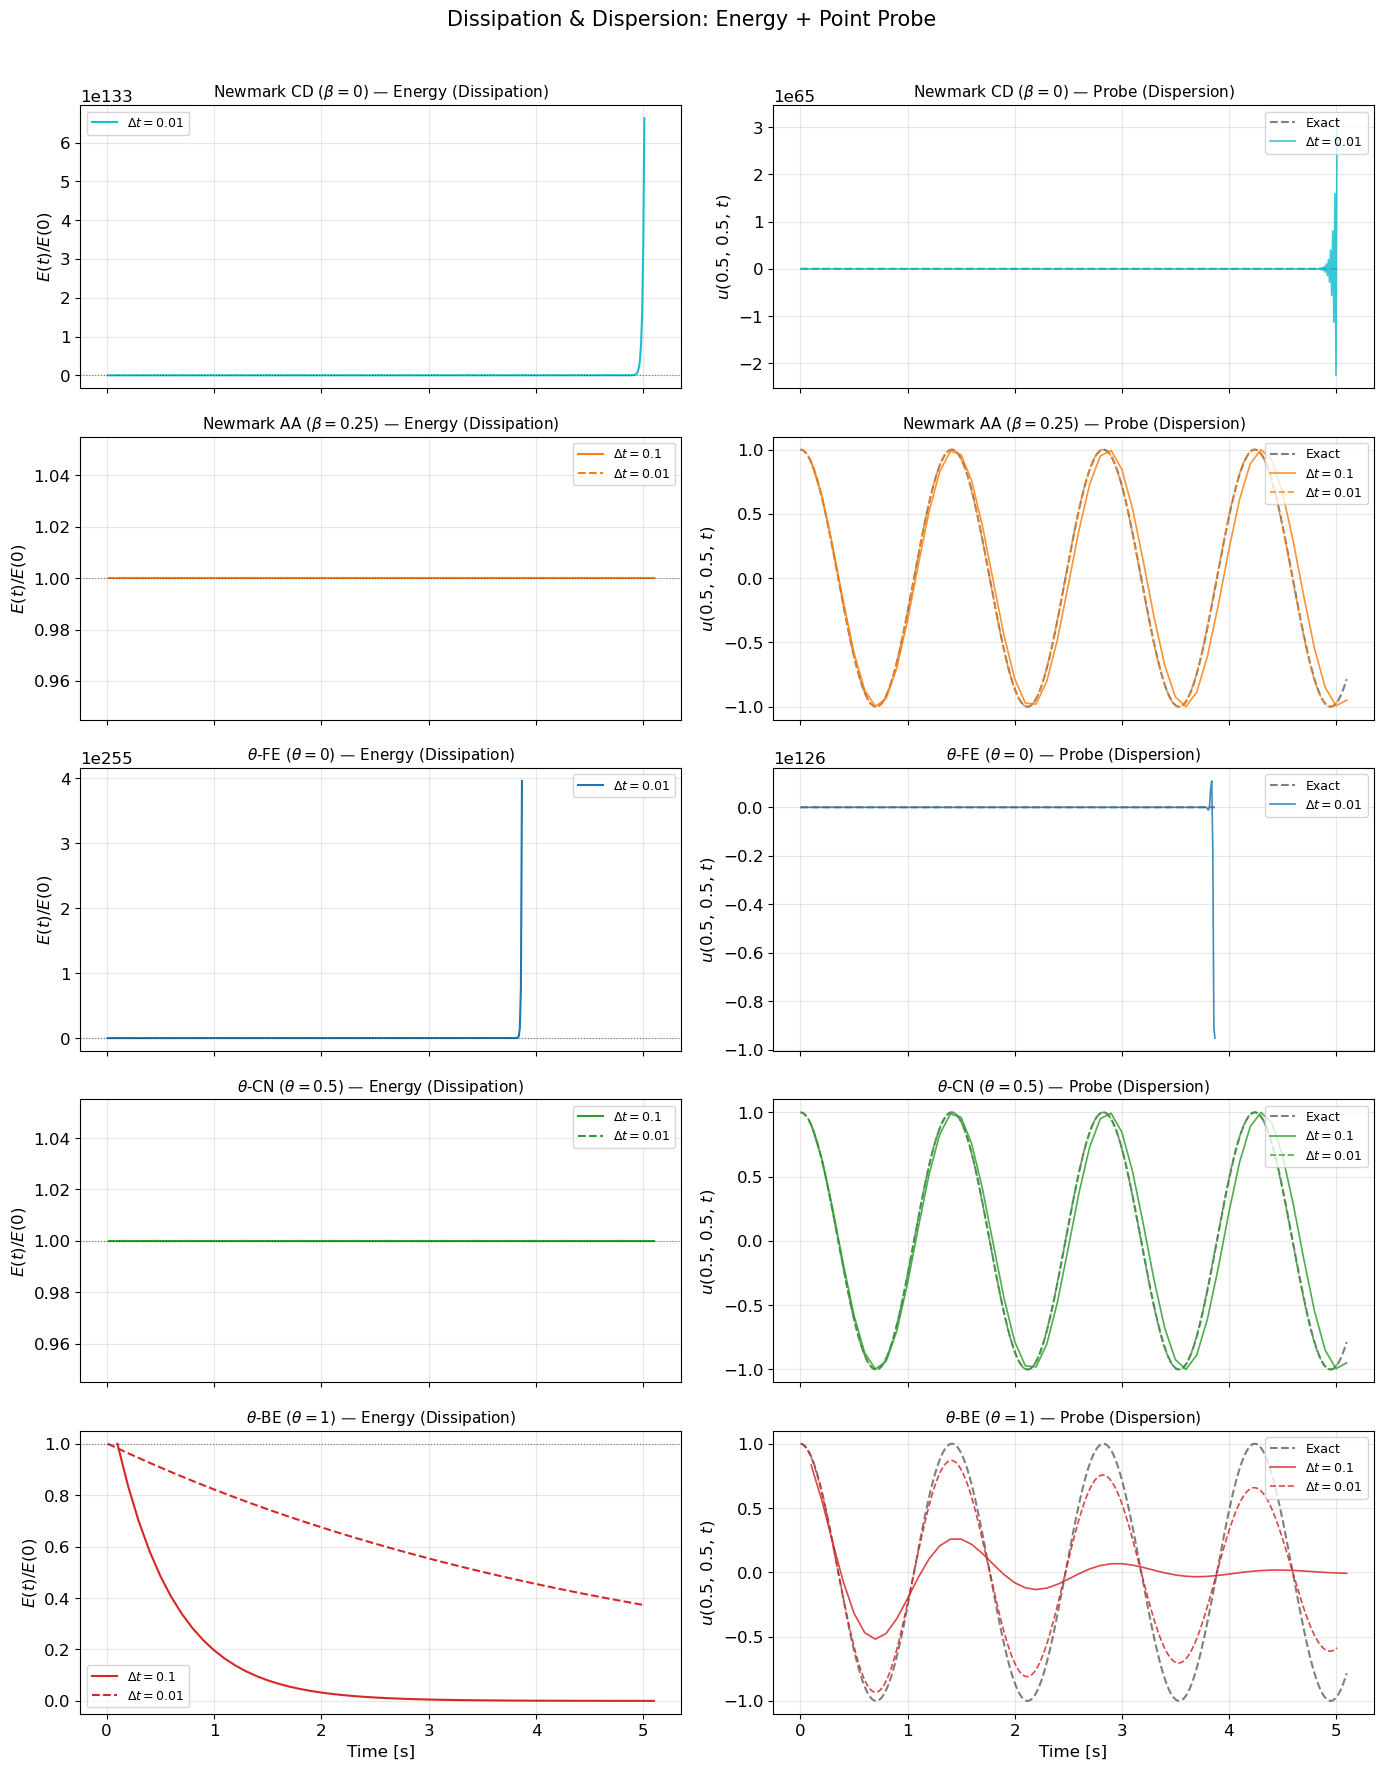

In [11]:
# ================================================================
# Side-by-side: Energy + Probe for a representative dt per scheme
# ================================================================

if probe_series and energy_series:
    # Pick the largest dt that is available for each scheme (most visible effects)
    schemes_present = sorted(set(k[0] for k in probe_series))

    fig, axes = plt.subplots(len(schemes_present), 2,
                             figsize=(14, 3.5 * len(schemes_present)),
                             sharex="col")
    if len(schemes_present) == 1:
        axes = axes[np.newaxis, :]

    for i, scheme in enumerate(schemes_present):
        # Find the dt values available in both energy and probe
        common_dts = sorted(
            set(k[1] for k in probe_series if k[0] == scheme) &
            set(k[1] for k in energy_series if k[0] == scheme),
            reverse=True
        )

        # Pick largest dt (most visible dissipation/dispersion) and smallest (best approximation)
        dts_to_show = []
        if len(common_dts) >= 2:
            dts_to_show = [common_dts[0], common_dts[-1]]  # largest, smallest
        elif common_dts:
            dts_to_show = [common_dts[0]]

        color = SCHEME_COLORS.get(scheme, "gray")

        # Energy panel
        ax_e = axes[i, 0]
        for dt_val in dts_to_show:
            edf = energy_series[(scheme, dt_val)]
            E0 = edf["energy"].iloc[0]
            linestyle = "-" if dt_val == dts_to_show[0] else "--"
            ax_e.plot(edf["time"], edf["energy"] / E0,
                      color=color, ls=linestyle, lw=1.5,
                      label=rf"$\Delta t = {dt_val}$")
        ax_e.axhline(1.0, color="k", ls=":", lw=0.8, alpha=0.5)
        ax_e.set_ylabel(r"$E(t)/E(0)$")
        ax_e.set_title(f"{SCHEME_LABELS.get(scheme, scheme)} — Energy (Dissipation)", fontsize=11)
        ax_e.legend(fontsize=9)

        # Probe panel
        ax_p = axes[i, 1]
        T_end = probe_series[(scheme, dts_to_show[0])]["time"].iloc[-1]
        t_fine = np.linspace(0, T_end, 3000)
        u_exact = np.cos(OMEGA_EXACT * t_fine)
        ax_p.plot(t_fine, u_exact, "k--", lw=1.5, alpha=0.5, label="Exact")

        for dt_val in dts_to_show:
            pdf = probe_series[(scheme, dt_val)]
            linestyle = "-" if dt_val == dts_to_show[0] else "--"
            ax_p.plot(pdf["time"], pdf["u_probe"],
                      color=color, ls=linestyle, lw=1.2, alpha=0.85,
                      label=rf"$\Delta t = {dt_val}$")

        ax_p.set_ylabel(r"$u(0.5,\,0.5,\,t)$")
        ax_p.set_title(f"{SCHEME_LABELS.get(scheme, scheme)} — Probe (Dispersion)", fontsize=11)
        ax_p.legend(fontsize=9, loc="upper right")

    axes[-1, 0].set_xlabel("Time [s]")
    axes[-1, 1].set_xlabel("Time [s]")
    fig.suptitle("Dissipation & Dispersion: Energy + Point Probe", fontsize=15, y=1.01)
    fig.tight_layout()
    fig.savefig(FIG_DIR / "side_by_side_energy_probe.pdf", bbox_inches="tight", dpi=150)
    fig.savefig(FIG_DIR / "side_by_side_energy_probe.png", bbox_inches="tight", dpi=150)
    plt.show()
else:
    print("Need both energy and probe data. Run the sweep after rebuilding.")

## 9. Summary Table

A concise comparison table of all schemes and their dissipation/dispersion properties.

In [12]:
# ================================================================
# Summary comparison table
# ================================================================

summary_data = {
    "Scheme": [
        r"θ-FE (θ=0)",
        r"θ-CN (θ=0.5)",
        r"θ-BE (θ=1)",
        r"Newmark CD (β=0)",
        r"Newmark AA (β=0.25)",
    ],
    "Stability": [
        "Conditional (Ω < 1)",
        "Unconditional",
        "Unconditional",
        "Conditional (Ω < 2)",
        "Unconditional",
    ],
    "Dissipation (Energy)": [
        "E grows (|g|>1, unstable)",
        "E conserved (|g|=1)",
        "E decays (|g|<1)",
        "E grows if Ω>2",
        "E conserved (|g|=1)",
    ],
    "Dispersion (Probe)": [
        "Phase lag, O(Δt²)",
        "Phase lag, O(Δt²)",
        "Phase lag, O(Δt²)",
        "Phase lag, O(Δt²)",
        "Phase lag, O(Δt²)",
    ],
    "Temporal Accuracy": [
        "1st order",
        "2nd order",
        "1st order",
        "2nd order",
        "2nd order",
    ],
}

df_summary = pd.DataFrame(summary_data)

try:
    styled = df_summary.style.set_properties(**{
        'text-align': 'center',
        'border': '1px solid #ccc',
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
    ]).hide(axis="index")
    display(styled)
except Exception:
    print(df_summary.to_string(index=False))

print("\nKey observations:")
print("  • Dissipation → look at E(t)/E(0): CN and Newmark AA conserve energy exactly.")
print("  • Dispersion  → look at u_h(0.5,0.5,t) vs cos(√2·π·t): phase drift visible for large Δt.")
print("  • BE (θ=1) shows BOTH amplitude decay AND phase shift.")
print("  • CN and Newmark AA are the best: energy-conserving + 2nd-order accurate.")
print("  • FE (θ=0) and CD (β=0) are conditionally stable — CFL restriction required.")

Scheme,Stability,Dissipation (Energy),Dispersion (Probe),Temporal Accuracy
θ-FE (θ=0),Conditional (Ω < 1),"E grows (|g|>1, unstable)","Phase lag, O(Δt²)",1st order
θ-CN (θ=0.5),Unconditional,E conserved (|g|=1),"Phase lag, O(Δt²)",2nd order
θ-BE (θ=1),Unconditional,E decays (|g|<1),"Phase lag, O(Δt²)",1st order
Newmark CD (β=0),Conditional (Ω < 2),E grows if Ω>2,"Phase lag, O(Δt²)",2nd order
Newmark AA (β=0.25),Unconditional,E conserved (|g|=1),"Phase lag, O(Δt²)",2nd order



Key observations:
  • Dissipation → look at E(t)/E(0): CN and Newmark AA conserve energy exactly.
  • Dispersion  → look at u_h(0.5,0.5,t) vs cos(√2·π·t): phase drift visible for large Δt.
  • BE (θ=1) shows BOTH amplitude decay AND phase shift.
  • CN and Newmark AA are the best: energy-conserving + 2nd-order accurate.
  • FE (θ=0) and CD (β=0) are conditionally stable — CFL restriction required.
